<a href="https://colab.research.google.com/github/morgdu/671_final/blob/master/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Book Reccomendations Systems 

imports/installs necessary for project

In [0]:
!pip install surprise

     |████████████████████████████████| 6.5MB 2.9MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678210 sha256=02de214c180ff59709cc8e058fa3a93b51ff2a76308a73bec65c7aff5d1a5990
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
# imports
import io
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse

## Content-Based Reccommendations

### Data Pre-Processing
---

In [0]:
from google.colab import files
uploaded = files.upload()

Saving books.csv to books.csv
Saving description.csv to description.csv
Saving listing.csv to listing.csv


In [0]:
import io

# load book description table
books_w_text = pd.read_csv(io.BytesIO(uploaded['description.csv']), sep=',', error_bad_lines=False, encoding='latin-1')
books_w_text.columns = ['book_id', 'name', 'description']
books_w_text.head()

,book_id,name,description
0,4833.0,The Glass Castle,"A tender, moving tale of unconditional love in..."
1,590.0,"Night (The Night Trilogy, #1)","Born into a Jewish ghetto in Hungary, as a chi..."
2,4264.0,"Angela's Ashes (Frank McCourt, #1)",Imbued on every page with Frank McCourt's asto...
3,3361.0,"Eat, Pray, Love","A celebrated writer's irresistible, candid, an..."
4,4535.0,Into Thin Air: A Personal Account of the Mount...,A bank of clouds was assembling on the not-so-...


The plot description has useful information, but I first need to remove the stop words that are unnecessary and unimportant information. Stop words are words such as then, and, etc. that do not contribute to the meaning. Then the simplified plot desriptions can be comverted into matrix using TF-IDF.

In [0]:
# removing the stop words
books_tfidf = TfidfVectorizer(stop_words='english')

# filling the missing values with empty string
books_w_text['description'] = books_w_text['description'].fillna('')

# computing TF-IDF
book_description_matrix = books_tfidf.fit_transform(books_w_text['description'])

In [0]:
cosine_similarity = linear_kernel(book_description_matrix, book_description_matrix)

In [0]:
indices = pd.Series(books_w_text['name'].index)

In [0]:
get the most similar books
def recommend(index, cosine_sim=cosine_similarity):
    id = indices[index]
    # Get similarity scores 
    similarity_scores = list(enumerate(cosine_sim[id]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:6]

    # Get the books index
    books_index = [i[0] for i in similarity_scores]

    # Return the top 5 most similar
    return books_w_text['name'].iloc[books_index]

In [0]:
books_w_text.iloc[[1]]

,book_id,name,description
1,590.0,"Night (The Night Trilogy, #1)","Born into a Jewish ghetto in Hungary, as a chi..."


In [0]:
recommend(1)

20     Maus I: A Survivor's Tale: My Father Bleeds Hi...
12                       The Autobiography of Malcolm X 
137    Beyond Courage: The Untold Story of Jewish Res...
13     The Hiding Place: The Triumphant True Story of...
69                                   The Words of Gandhi
Name: name, dtype: object

In [0]:
# load book description table
books = pd.read_csv(io.BytesIO(uploaded['books.csv']), sep=',', error_bad_lines=False, encoding='latin-1')
books = books.drop(columns = ['avg_rating', 'no_of_ratings'])
cols = ['user_id', 'book_id', 'user_rating']
books = books[cols]
books.head()

,user_id,book_id,user_rating
0,3466,4833,0
1,3466,590,5
2,3453,4264,5
3,3453,3361,4
4,3453,4535,0


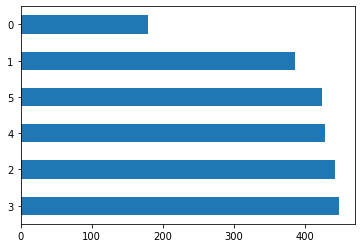

In [0]:
books['user_rating'].value_counts().plot(kind='barh')

In [0]:
reader2 = Reader(rating_scale=(1, 10))
data2 = Dataset.load_from_df(books[['user_id', 'book_id', 'user_rating']], reader2)

In [0]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data2, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [0]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [0]:
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,1.570588,0.003017,0.004067
SVD,1.591286,0.097980,0.006528
SVDpp,1.611158,1.326721,0.050961
KNNWithMeans,1.871705,0.003284,0.008326
KNNBaseline,1.875103,0.004213,0.009475
KNNWithZScore,1.900013,0.008805,0.009327
CoClustering,1.901514,0.100923,0.004430
KNNBasic,1.904400,0.001200,0.010325
SlopeOne,1.967050,0.012372,0.025611


## Collaborative Filtering (using Surprise package)
### Data Pre-Processing

---

In [0]:
from google.colab import files
uploaded = files.upload()

Saving BX-Book-Ratings.csv to BX-Book-Ratings (1).csv
Saving BX-Users.csv to BX-Users (1).csv


In [0]:
import io

# load user info table 
user = pd.read_csv(io.BytesIO(uploaded['BX-Users.csv']), sep=';', error_bad_lines=False, encoding='latin-1')
user.columns = ['userID', 'Location', 'Age']

# load rating info table
rating = pd.read_csv(io.BytesIO(uploaded['BX-Book-Ratings.csv']), sep=';', error_bad_lines=False, encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']

# connect user info to their rating with join on user ID as key
df = pd.merge(user, rating, on='userID', how='inner')
df.head()

,userID,Location,Age,ISBN,bookRating
0,2,"stockton, california, usa",18.0,0195153448,0
1,7,"washington, dc, usa",NaN,034542252,0
2,8,"timmins, ontario, canada",NaN,0002005018,5
3,8,"timmins, ontario, canada",NaN,0060973129,0
4,8,"timmins, ontario, canada",NaN,0374157065,0


We can see in the above data frame with the raw data that there are a lot of ratings of zero. However, on the metadata it says ratings are a score 1-10. This means that rating of 0 should really be treated as a not available rating and the missing data needs to be filled with the another value. I chose the mean.

In [0]:
df['bookRating'] = df['bookRating'].replace(0, np.nan) # replace zeros with NaN because ratings are 1 - 10 and a rating of zero should be treated as no rating
df['bookRating'] = df['bookRating'].fillna(df['bookRating'].mean()) # impute missing values with mean
df.head()

,userID,Location,Age,ISBN,bookRating
0,2,"stockton, california, usa",18.0,0195153448,7.601066
1,7,"washington, dc, usa",NaN,034542252,7.601066
2,8,"timmins, ontario, canada",NaN,0002005018,5.000000
3,8,"timmins, ontario, canada",NaN,0060973129,7.601066
4,8,"timmins, ontario, canada",NaN,0374157065,7.601066


In [0]:
df.shape

(1149780, 5)

Right now there are over a million records. This will be a lot of data to process, so I want to filter out only the important books. Books that have been rated more than 50 times have more valuable and reliable insights than those that have only bee rated a few times, so I filter out the dataset to only include books with 50 or more ratings. This reduces the data to a more manageable set of about 140,000 records. In addition to faster processing times, this is also more reliable information to use for analysis.

In [0]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]

In [0]:
df_new.shape

(140516, 5)

In [0]:
df_new.head()

,userID,Location,Age,ISBN,bookRating
394,243,"arden hills, minnesota, usa",NaN,0060915544,10.000000
395,243,"arden hills, minnesota, usa",NaN,0060977493,7.000000
397,243,"arden hills, minnesota, usa",NaN,0156006529,7.601066
400,243,"arden hills, minnesota, usa",NaN,0316096199,7.601066
401,243,"arden hills, minnesota, usa",NaN,0316601950,9.000000


A majority of the ratings were replaced by the average. This will probably skew the data and affect prediction results.

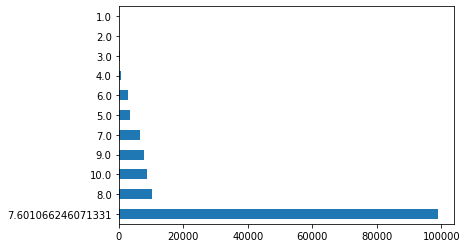

In [0]:
df_new['bookRating'].value_counts().plot(kind='barh')

The Reader class from the Surprise package is used to parse a file containing ratings. The file should have only one rating per line and each line should be in the format (user, item, rating) which is the format of the data frame above.

In [0]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

### Exploratory Data Analysis
---

I then compare the performance of 11 different algorithms for the collaborative filtering predictions. A three fold cross validation split is used and RMSE is the measure of accuracy.

In [0]:
benchmark = []

In [0]:
results1 = cross_validate(SlopeOne(), data, measures=['RMSE'], cv=3, verbose=False)
r = pd.DataFrame.from_dict(results1).mean(axis=0)
r = r.append(pd.Series([str(SlopeOne()).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(r)

In [0]:
results2 = cross_validate(SVD(), data, measures=['RMSE'], cv=3, verbose=False)
r = pd.DataFrame.from_dict(results2).mean(axis=0)
r = r.append(pd.Series([str(SVD()).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(r)

In [0]:
results3 = cross_validate(SVDpp(), data, measures=['RMSE'], cv=3, verbose=False)
r = pd.DataFrame.from_dict(results3).mean(axis=0)
r = r.append(pd.Series([str(SVDpp()).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(r)

In [0]:
results4 = cross_validate(NMF(), data, measures=['RMSE'], cv=3, verbose=False)
r = pd.DataFrame.from_dict(results4).mean(axis=0)
r = r.append(pd.Series([str(NMF()).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(r)

In [0]:
results5 = cross_validate(NormalPredictor(), data, measures=['RMSE'], cv=3, verbose=False)
r = pd.DataFrame.from_dict(results5).mean(axis=0)
r = r.append(pd.Series([str(NormalPredictor()).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(r)

In [0]:
results6 = cross_validate(KNNBaseline(), data, measures=['RMSE'], cv=3, verbose=False)
r = pd.DataFrame.from_dict(results6).mean(axis=0)
r = r.append(pd.Series([str(KNNBaseline()).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(r)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [0]:
results7 = cross_validate(KNNBasic(), data, measures=['RMSE'], cv=3, verbose=False)
r = pd.DataFrame.from_dict(results7).mean(axis=0)
r = r.append(pd.Series([str(KNNBasic()).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(r)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [0]:
results8 = cross_validate(KNNWithMeans(), data, measures=['RMSE'], cv=3, verbose=False)
r = pd.DataFrame.from_dict(results8).mean(axis=0)
r = r.append(pd.Series([str(KNNWithMeans()).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(r)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [0]:
results9 = cross_validate(KNNWithZScore(), data, measures=['RMSE'], cv=3, verbose=False)
r = pd.DataFrame.from_dict(results9).mean(axis=0)
r = r.append(pd.Series([str(KNNWithZScore()).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(r)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [0]:
results10 = cross_validate(BaselineOnly(), data, measures=['RMSE'], cv=3, verbose=False)
r = pd.DataFrame.from_dict(results10).mean(axis=0)
r = r.append(pd.Series([str(BaselineOnly()).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(r)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [0]:
results11 = cross_validate(CoClustering(), data, measures=['RMSE'], cv=3, verbose=False)
r = pd.DataFrame.from_dict(results11).mean(axis=0)
r = r.append(pd.Series([str(CoClustering()).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(r)

Make dataframe out of results that compares algorithms. RMSE is the metric of accuracy I am using the evaluate the algorithms. RMSE is root mean square error and is a masure of absolute fit. It is the units of the target variable (1-10 points of rating). Most of the algorithms have about 1-2 points of RMSE, with BaselineOnly being the best performing.

In [0]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [0]:
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.906685,0.309659,0.347130
KNNBaseline,0.913300,1.029761,6.756752
SVDpp,0.916951,133.341047,6.334580
SVD,0.917551,6.123568,0.517167
KNNWithMeans,0.922130,0.793544,5.648187
KNNWithZScore,0.926704,0.927840,6.144832
KNNBasic,0.953086,0.735153,5.357682
SlopeOne,0.965562,0.900631,4.653143
CoClustering,1.052916,2.372522,0.386183


### Training Model
---
Because BaselineOnly algorithm performed the best, I use it to train the final predictions model using Surprise package. ALS (Alternating Least Squares) is the baseline method used.

In [0]:
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'fit_time': (0.15193462371826172, 0.17780303955078125, 0.18294978141784668),
 'test_rmse': array([0.90995021, 0.90924263, 0.89895632]),
 'test_time': (0.3519935607910156, 0.34478235244750977, 0.3396124839782715)}

The model is trained and tested on a split of the data and predictions are made. The predictions are then compared to the actual ratings to measure accuracy.

In [0]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.9050


0.9050082185371785